In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
%matplotlib inline

import galsim

from astropy.io import fits
import pickle
from helperFunctions import *

In [3]:
scratchdir = '/global/cscratch1/sd/chebert/rawSpeckles/'

In [79]:
# find all image files in the scratch directory
fileNames = ! ls /global/cscratch1/sd/chebert/rawSpeckles/ | grep 'img' 
fileNames = [f for f in fileNames if f not in ['img_a_004.fits', 'img_a_388.fits', 'img_a_389.fits']]

In [ ]:
# check image shapes
for file in fileNames:
    hdu = fits.open(scratchdir + file)
    img = hdu[0].data[0]
    hdu.close
    if np.shape(img) != (256, 256):
        print(f'{file}: {np.shape(img)}')
print(f'done! found {len(fileNames)} files')

## Gain and ADU conversion

In [78]:
# gains = {}
# for file in fileNames:
#     hdu = fits.open(scratchdir + file)
#     gains[file] = hdu[0].header['GAIN']
#     hdu.close()

# realGain_ADU = {'0': 2.5,
#                 '2': 2.5,
#                 '3': 2.5,
#                 '10': 3,
#                 '20': 3.5,
#                 '100': 9,
#                 '140': 20,
#                 '210': 200,
#                 '250': 550
#                }

# realGain_e = {(k, realGain_ADU[str(v)] * 22.42) for (k,v) in gains.items()}

# with open('./eConversionWithGain.p', 'wb') as file:
#     pickle.dump(realGain_e, file)

In [ ]:
# open the conversion/gain dictionary:
with open('./eConversionWithGain.p', 'rb') as file:
    aduConversionWithGain = pickle.load(file)

## Screen for full length datasets

In [ ]:
# for file in fileNames:
#     hdu = fits.open(scratchdir + file)
#     series = hdu[0].data
#     hdu.close
    
#     fig, axes = plt.subplots(1, 10, figsize=(18,2))
#     for i in range(10):
#         axes[i].imshow(series[i*100])
    
#     print(file)
#     plt.show()

Questionable files are:

a filter: 004, 207 (kinda), 381 (kinda), 388, 389

b filter: 004, 388, 389

## Screen for size/position of PSF

In [5]:
comDictA = {}
fwhmDictA = {}
for file in fileNames[:int(len(fileNames)/2)]:
    if file not in ['img_a_004.fits', 'img_a_388.fits', 'img_a_389.fits']:
        hdu = fits.open(scratchdir + file)
        series = hdu[0].data
        hdu.close
        
        com = 0
        fwhm = 0
        for i in range(20):
            x, y = imageCOM(series[i * 50])
            fwhm += imageFWHM(series[i * 50], x, y)
            com += np.sqrt((x - 128)**2 + (y - 128)**2)
            
        comDictA[file] = com / 20
        fwhmDictA[file] = fwhm / 20

In [77]:
with open('./../Fits/centerOfMassA.p', 'wb') as file:
    pickle.dump(comDictA, file)
with open('./../Fits/fwhmA.p', 'wb') as file:
    pickle.dump(fwhmDictA, file)

In [6]:
comDictB = {}
fwhmDictB = {}
for file in fileNames[int(len(fileNames)/2):]:
    if file not in ['img_b_004.fits', 'img_b_388.fits', 'img_b_389.fits']:
        hdu = fits.open(scratchdir + file)
        series = hdu[0].data
        hdu.close
        
        com = 0
        fwhm = 0
        for i in range(20):
            x, y = imageCOM(series[i * 50])
            fwhm += imageFWHM(series[i * 50], x, y)
            com += np.sqrt((x - 128)**2 + (y - 128)**2)
            
        comDictB[file] = com / 20
        fwhmDictB[file] = fwhm / 20

In [76]:
with open('./../Fits/centerOfMassB.p', 'wb') as file:
    pickle.dump(comDictB, file)
with open('./../Fits/fwhmB.p', 'wb') as file:
    pickle.dump(fwhmDictB, file)

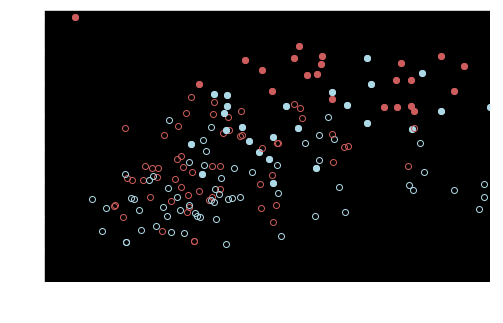

25


In [90]:
rejected = 0
plt.figure(figsize=(8,5))

for (k, v) in comDictB.items():
    k_a = k.split('_')[0] + '_a_' + k.split('_')[-1]
#     if k == 'img_b_025.fits':
#         plt.plot(v, fwhmDictB[k], 'o', color='lightblue', fillstyle='none', label='filter b')
#         plt.plot(comDictA[k_a], fwhmDictA[k_a], 'o', color='indianred', fillstyle='none', label='filter a')
#         plt.plot(v, fwhmDictB[k], 'o', color='lightblue', label='b; rejected')
#         plt.plot(comDictA[k_a], fwhmDictA[k_a], 'o', color='indianred', label='a; rejected')

    plt.plot(v, fwhmDictB[k], 'o', color='lightblue', fillstyle='none')
    plt.plot(comDictA[k_a], fwhmDictA[k_a], 'o', color='indianred', fillstyle='none')
    
    if v + 2*fwhmDictB[k] >= 128 or comDictA[k_a] + 2*fwhmDictA[k_a] >= 128:
        rejected += 1
        plt.plot(v, fwhmDictB[k], 'o', color='lightblue')
        plt.plot(comDictA[k_a], fwhmDictA[k_a], 'o', color='indianred')
        
plt.xlabel('PSF center offset (center of mass)', fontsize=12)
plt.ylabel('PSF size (FWHM)', fontsize=12)
plt.ylim([0,82])
plt.xlim([-1,35])
# plt.legend()
plt.show()
print(rejected)

### Examples of accepted/rejected images

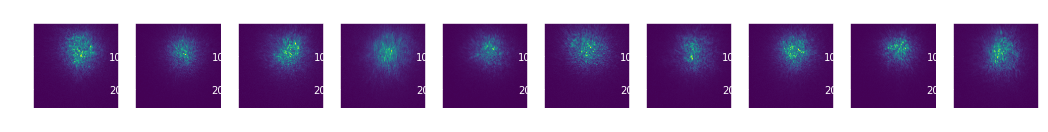

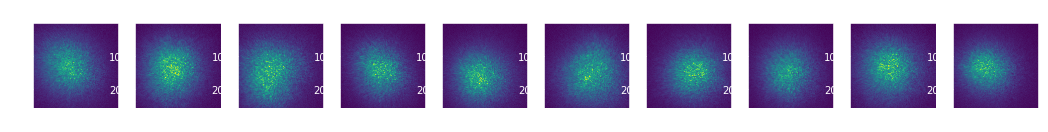

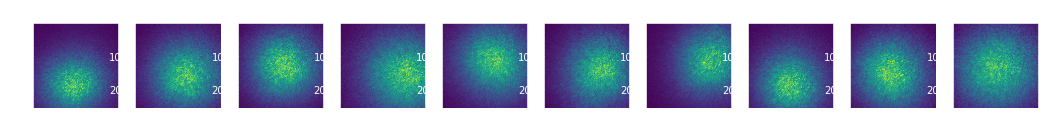

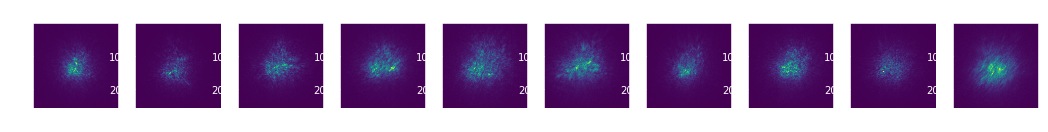

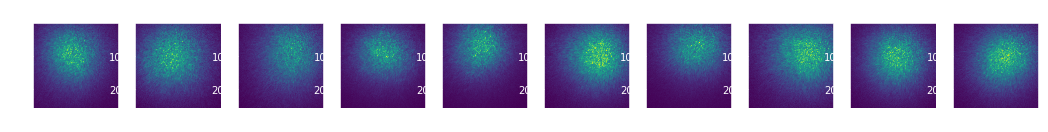

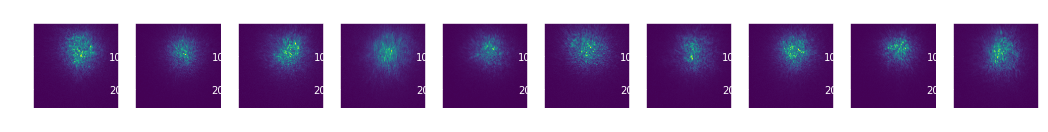

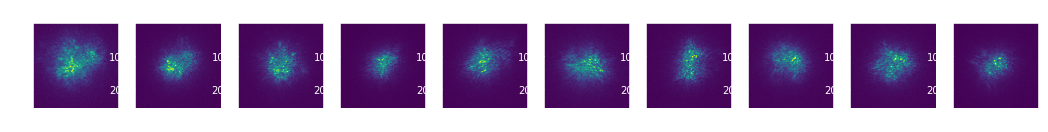

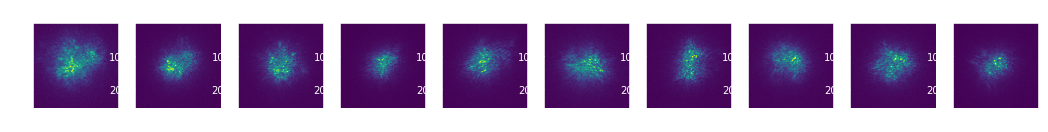

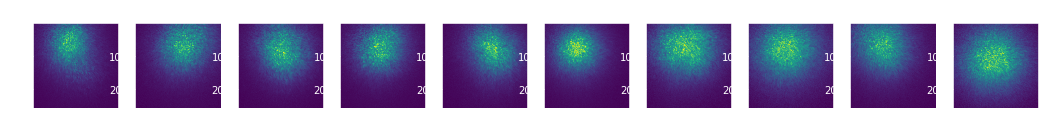

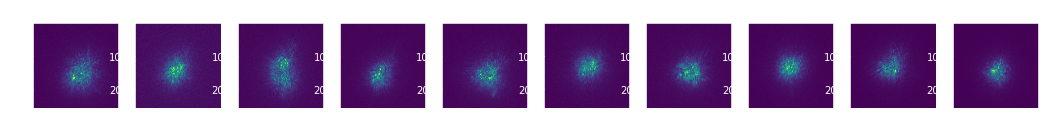

In [56]:
for j in range(10):
    k_a = np.random.choice(list(comDictA.keys()))
    com = comDictA[k_a]
    fwhm = fwhmDictA[k_a]

    hdu = fits.open(scratchdir + k_a)
    series = hdu[0].data
    hdu.close()

    if com + 2*fwhm >= 128:
        status = 'rejected'
    else:
        status = 'accepted'

    fig, axes = plt.subplots(1, 10, figsize=(18,2))
    axes[0].set_title(status)
    for i in range(10):
        axes[i].imshow(series[i*100])

## Exploring Header Info

In [ ]:
hduA = fits.open(scratchdir + 'img_a_051.fits')
hduB = fits.open(scratchdir + 'img_b_051.fits')

In [ ]:
quantity = 'KCT'
hduA[0].header[quantity], hduB[0].header[quantity]
hduA[0].header['EXPOSURE'] - hduA[0].header['KCT'], hduB[0].header['EXPOSURE'] - hduB[0].header['KCT']